In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import geopandas as gpd
import xarray as xr

from odc.ui import with_ui_cbk, DcViewer

sys.path.insert(0, 'index_factory/indices/tools')
from indices.tools.bandindices import s2_indices
from indices.tools.plotting import rgb
#from eo2cube_tools import plot

import datetime
from datacube.utils.cog import write_cog

In [2]:
dc = datacube.Datacube(app='indices', config = '/home/datacube/.datacube.conf')

In [3]:
# choose saldi-site: [1,2,3,4,5,6]
site = 5

# adjust start of the moving calendar week
year = 2020
month = 1
day = 1

# initiate a list of indices: [NDVI;RVI;EVI;PVI;DVI;REIP;SAVI;MSAVI;TSAVI;NDBI;NDWI]
#index=['NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDBI', 'NDWI']
#index=['RVI', 'PVI', 'DVI', 'REIP', 'TSAVI']
index=['RVI', 'PVI', 'DVI', 'REIP', 'TSAVI','NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDBI', 'NDWI']

setSite = str(site)
setYear = str(year)
shapefile = 'SALDi_0'+setSite+'.shp'
product = 's2_l2a_saldi_0'+setSite
saldiSite = "saldi_0"+setSite

In [4]:
shp = gpd.read_file('/datacube/notebooks/kluter/index_factory/saldi_sites/' + shapefile)
#plot.map_polygon(shp)

if site == 1: 
    shp = shp.to_crs('epsg:32734')
elif site == 2:
    shp = shp.to_crs('epsg:32734')
elif site == 3:
    shp = shp.to_crs('epsg:32735')
elif site == 4:
    shp = shp.to_crs('epsg:32735')
elif site == 5:
    shp = shp.to_crs('epsg:32735')
elif site == 6:
    shp = shp.to_crs('epsg:32736')
else:
    print('Error: saldi-site does not exist.')
    
crs = shp.crs

longitude_extents = (shp.total_bounds[0], shp.total_bounds[2])
latitude_extents  = (shp.total_bounds[1], shp.total_bounds[3])
#print('\n Maximal shapefile extents:\n\n', 'x:', latitude_extents, '\n y:', longitude_extents, '\n')

In [ ]:
for i in range(54)[1:]:

    start = datetime.datetime(year, month, day) 
    end = start + datetime.timedelta(6) 
    startString = start.strftime('%Y-%m-%d')
    endString = end.strftime('%Y-%m-%d')
    
    end = end + datetime.timedelta(1)
    year = int(end.strftime('%Y'))
    month = int(end.strftime('%m'))
    day = int(end.strftime('%d'))

    if start >= datetime.datetime(int(setYear)+1, 1, 1):
        break
    elif end >= datetime.datetime(int(setYear)+1, 1, 1):
        end = datetime.datetime(int(setYear), 12, 31)
        endString = end.strftime('%Y-%m-%d')
    
    now = datetime.datetime.now().strftime("%H:%M:%S")
    print(now + '    ' + startString + '    ' + endString + '    Week - ' + str(i))
    
    
    dataset = dc.load(product = product,
                          x=longitude_extents,
                          y=latitude_extents,
                          crs=crs,
                          time=(startString, endString),
                          group_by='solar_day',
                          progress_cbk=with_ui_cbk())
    
    
    if str(dataset.coords)[-7:] != '*empty*':
    
        now = datetime.datetime.now().strftime("%H:%M:%S")
        print(now + '    ' + 'Dataset: ' + str(year) + '  -  Week ' + str(i) + ' loaded.' + '\n')
        now = datetime.datetime.now().strftime("%H:%M:%S")
        print(now + '    ' + 'Computing Index.')

        s2_indices(dataset, 
               index=index, 
               inplace=True)

        now = datetime.datetime.now().strftime("%H:%M:%S")
        print(now + '    ' + str(index) + ' - computed.'+'\n')


        for k in range(len(index)):

            exe0 = 'dataset.'+index[k]+'.isel(time=j)'
            exe1 = 'dataset.'+index[k]+'.time'
            exe2 = 'dataset.'+index[k]+'.time[j].values'

            for j in range(len(eval(exe1))):
                name = str(eval(exe2))
                write_cog(geo_im=eval(exe0),
                          fname='/datacube/notebooks/kluter/index_factory/output/'+
                                  setYear + '/' +
                                  saldiSite + '/' +
                                  index[k] + '/' +
                                  saldiSite + '_' + index[k] + '_' + name + '.tiff',
                                  overwrite=True)

                now = datetime.datetime.now().strftime("%H:%M:%S")
                print(now + '    ' + index[k] + '.tiff - ' + str(j+1) + ' of ' + str(len(eval(exe1))) + ' exported.')

        print('\n\n')

In [6]:
dataset = dc.load(product = product,
                  x=longitude_extents,
                  y=latitude_extents,
                  crs='EPSG:32735',
                  time=('2016-01-03', '2016-01-05'),
                  group_by='solar_day',
                  progress_cbk=with_ui_cbk())

#s2_indices(dataset, 
 #          index=['NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDBI', 'NDWI'], 
  #         inplace=True)
    
#name=str(dataset.EVI.time[0].values)
    
#write_cog(geo_im=dataset.EVI.isel(time=0),
#          fname='/datacube/notebooks/kluter/index_factory/output/2020/saldi_01/EVI/saldi_01_EVI_'+name+'.tiff',
#          overwrite=True)
    
#index_factory/output/2020/saldi_01/EVI/saldi_01_EVI_2020-01-01T08:49:41.690279000.tiff

In [12]:
DcViewer(dc=dc,
         time='2016-01-01',
         width='1100px',
         center=(-20.00, 27.00),
         zoom=4)

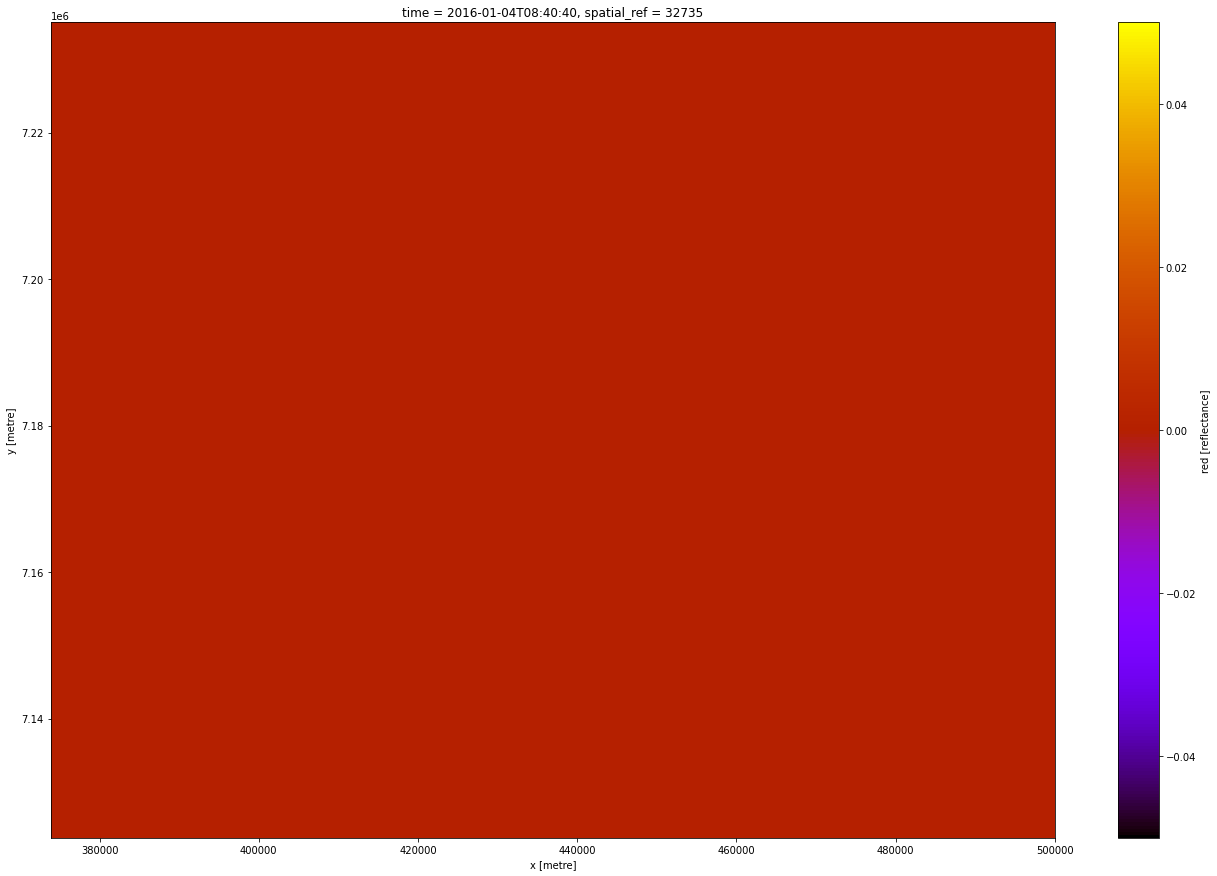

In [11]:
dataset.red.plot(size=15, cmap="gnuplot")

In [ ]:
#    now = datetime.datetime.now().strftime("%H:%M:%S")
#    print(now + '    ' + str(index) + ' - computed.'+'\n')
    
    
#    for k in range(len(index)):
#    
#        exe0 = 'dataset.'+index[k]+'.isel(time=j)'
#        exe1 = 'dataset.'+index[k]+'.time'
#        exe2 = 'dataset.'+index[k]+'.time[j].values'

#        for j in range(len(eval(exe1))):
#            name = str(eval(exe2))
#            write_cog(geo_im=eval(exe0),
#                      fname='/datacube/notebooks/kluter/index_factory/output/'+
#                              setYear + '/' +
#                              site + '/' +
#                              index[k] + '/' +
#                              site + '_' + index[k] + '_' + name + '.tiff',
#                              overwrite=True)
            
#            now = datetime.datetime.now().strftime("%H:%M:%S")
#            print(now + '    ' + index[k] + '.tiff - ' + str(j+1) + ' of ' + str(len(eval(exe1))) + ' exported.')

#    print('\n\n')